**Import Libraries**

In [1]:
# Standard Libraries
import os
import copy
import random
from glob import glob
from PIL import Image
import timm

# Data Manipulation Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt

# Progress Bar
from tqdm import tqdm

# Machine Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from lightly.loss import NTXentLoss
from lightly.transforms.byol_transform import BYOLTransform, BYOLView1Transform, BYOLView2Transform
from lightly.models.modules import BYOLProjectionHead, BYOLPredictionHead
from lightly.models.utils import deactivate_requires_grad, update_momentum
from lightly.loss import NegativeCosineSimilarity
from lightly.utils.scheduler import cosine_schedule
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc

/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Define Parameters**

In [2]:
# Paths
ZIP_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14.zip'
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14-extracted'

# Define parameters
SEED = 42

# Parameteres fine tuning
LEARNING_RATE = 1e-2
TEST_SIZE = 0.8
EPOCHS = 6
BATCH_SIZE = 32

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


**Set Seed for Reproducibility**

In [3]:
def seed_everything(seed=SEED):
    """
    Sets the seed to ensure reproducibility.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensure deterministic behavior in CUDA operations
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Apply the seed
seed_everything()

# **Step 1: Load Data (Stage 1)**

In [4]:
def extract_data(zip_path, extracted_path):
    """
    Extracts the ZIP file of the dataset.
    """
    os.makedirs(extracted_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)
    print(f"Data extracted to {extracted_path}")

# Uncomment the line below to extract data (if not already extracted)
# extract_data(ZIP_PATH, EXTRACTED_PATH)

# **Step 2: Data Preprocessing (Stage 1)**

In [5]:
# Define Disease Labels
disease_labels = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]

def load_labels(csv_path, image_path):
    """
    Loads and preprocesses the labels from the CSV file.
    Maps each image to its corresponding file path and binary labels for each disease.
    """

    # Read the CSV file containing labels
    labels_df = pd.read_csv(csv_path)

    # Create binary columns for each disease label
    for disease in disease_labels:
        labels_df[disease] = labels_df['Finding Labels'].str.contains(disease).astype(int)

    # Create a binary column for 'No Finding'
    labels_df['No_Finding'] = labels_df['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

    # Map image filenames to their full paths
    image_paths = glob(os.path.join(image_path, '**', 'images', '*.png'), recursive=True)
    img_path_dict = {os.path.basename(path): path for path in image_paths}

    # Add the full image path to the dataframe
    labels_df['Path'] = labels_df['Image Index'].map(img_path_dict)
    return labels_df

# Path to the labels CSV file
labels_csv_path = os.path.join(EXTRACTED_PATH, 'Data_Entry_2017.csv')

# Load and preprocess the labels
labels_df = load_labels(labels_csv_path, EXTRACTED_PATH)

**Split Dataset**

In [6]:
# Remove all No finding labels for stage 1 training
labels_df_stage_2 = labels_df
labels_df = labels_df[labels_df['No_Finding'] != 1]

# Split patients into training/validation and test sets
unique_patients = labels_df['Patient ID'].unique()
train_val_patients, test_patients = train_test_split(
    unique_patients, test_size=0.2, random_state=SEED
)

# Create training/validation and test dataframes
train_val_df = labels_df[labels_df['Patient ID'].isin(train_val_patients)].reset_index(drop=True)
test_df = labels_df[labels_df['Patient ID'].isin(test_patients)].reset_index(drop=True)

# Verify Split Sizes
print(f"Train size: {train_val_df.shape[0]}")
print(f"Test size: {test_df.shape[0]}")

Train size: 41466
Test size: 10293


**Define Dataset for Chest X-ray images**

In [7]:
class ChestXrayDataset(Dataset):
    """
    Custom Dataset for Chest X-ray images.
    """
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image path and labels
        img_path = self.df.iloc[idx]['Path']
        image = plt.imread(img_path)
        label = self.df.iloc[idx][disease_labels].values.astype(np.float32)
        
        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
        
        return image, label

**Define Data Transformations**

In [8]:
# Define transformations for training data
train_transforms = transforms.Compose([

    # Convert image to PIL format for further transformations
    transforms.ToPILImage(),
    
    # Convert to grayscale and change to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize((224, 224)),

    # Apply random horizontal flip to augment the data
    transforms.RandomHorizontalFlip(),

    # Randomly rotate the image within a range of ±10 degrees
    transforms.RandomRotation(10),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Define transformations for test data
test_transforms = transforms.Compose([

    # Convert image to PIL format for further transformations
    transforms.ToPILImage(),

    # Convert to grayscale and change to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize((224, 224)),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

**Create Datasets**

In [9]:
train_dataset = ChestXrayDataset(train_val_df, transform=train_transforms)
test_dataset = ChestXrayDataset(test_df, transform=test_transforms)

**Split into Training and Validation**

In [10]:
train_size = int(TEST_SIZE * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

**Create DataLoaders**

In [11]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

# **Step 3: Build the Model (Stage 1)**

**Initialize the Multi-Label Classifier Model**

In [12]:
# Define the model
class MultiLabelClassifier(nn.Module):
    """
    Multi-Label Classification Model using Swin Transformer as the base model.
    """
    def __init__(self, num_classes=len(disease_labels)):
        super(MultiLabelClassifier, self).__init__()

        # Load pre-trained Swin Transformer model
        self.base_model = timm.create_model('coatnet_0_rw_224.sw_in1k', pretrained=True)

        # Replace the classification head to match the number of disease labels
        self.base_model.head.fc = nn.Linear(self.base_model.head.fc.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

# Initialize the Model
model = MultiLabelClassifier()
model.to(device)

MultiLabelClassifier(
  (base_model): MaxxVit(
    (stem): Stem(
      (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (norm1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
      (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (stages): Sequential(
      (0): MaxxVitStage(
        (blocks): Sequential(
          (0): MbConvBlock(
            (shortcut): Downsample2d(
              (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
              (expand): Conv2d(64, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
            )
            (pre_norm): BatchNormAct2d(
              64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): SiLU(inplace=True)
            )
            (down): Downsample2d(
            

**Define Loss Function and Optimizer**

In [13]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# **Step 4: Train the Model (Stage 1)**

**Step 1: Train Classification Head Only**

In [14]:
# Freeze the backbone parameters
for name, param in model.named_parameters():
    if "head" not in name:
        param.requires_grad = False

In [15]:
# Only the classifier parameters will be updated
optimizer_head = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer_head, step_size=2, gamma=0.1)

In [16]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):

    """
    Trains the model and evaluates it on the validation set after each epoch.
    """
    # List to store loss and AUC
    train_losses = []
    val_losses = []
    val_aucs = []

    for epoch in range(epochs):

        # Training
        model.train()
        train_loss = 0.0

        # Progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average training loss
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        all_labels = []
        all_preds = []

        # Progress bar
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs}")

        # Disable gradients for evaluation
        with torch.no_grad():
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                # Apply sigmoid
                preds = torch.sigmoid(outputs).cpu()

                # Store predictions and true labels
                all_preds.append(preds)
                all_labels.append(labels.cpu())
                
                progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average validation loss
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Concatenate all batches
        preds = torch.cat(all_preds)
        labels = torch.cat(all_labels)
    
        roc_auc_per_label = []

        # Compute metrics for each label
        for i, label in enumerate(disease_labels):

            # Calculate ROC AUC
            roc_auc = roc_auc_score(labels[:, i].numpy(), preds[:, i].numpy())
            roc_auc_per_label.append(roc_auc)

        # Calculate and add overall metrics
        mean_auc = np.mean(roc_auc_per_label)
        val_aucs.append(mean_auc)

        # Update the scheduler once per epoch.
        scheduler.step()
        
        print(f"Epoch {epoch+1}/{epochs} | Training Loss: {train_loss:.4f} | "
              f"Validation Loss: {val_loss:.4f} | Mean Validation AUC: {mean_auc:.4f}")

    return train_losses, val_losses, val_aucs

# Train the model for the desired number of epochs
train_losses, val_losses, val_aucs = train_model(model, train_loader, val_loader, criterion, optimizer_head, epochs=EPOCHS)

Epoch 1/6: 100%|██████████| 260/260 [00:35<00:00,  7.33it/s, Loss=0.363]


Epoch 1/6 | Training Loss: 0.3324 | Validation Loss: 0.3314 | Mean Validation AUC: 0.6641


Epoch 2/6: 100%|██████████| 260/260 [00:31<00:00,  8.22it/s, Loss=0.393]


Epoch 2/6 | Training Loss: 0.3281 | Validation Loss: 0.3687 | Mean Validation AUC: 0.6588


Epoch 3/6: 100%|██████████| 260/260 [00:31<00:00,  8.19it/s, Loss=0.332]


Epoch 3/6 | Training Loss: 0.2877 | Validation Loss: 0.2901 | Mean Validation AUC: 0.6953


Epoch 4/6: 100%|██████████| 260/260 [00:31<00:00,  8.16it/s, Loss=0.332]


Epoch 4/6 | Training Loss: 0.2808 | Validation Loss: 0.2863 | Mean Validation AUC: 0.7013


Epoch 5/6: 100%|██████████| 260/260 [00:30<00:00,  8.65it/s, Loss=0.295]


Epoch 5/6 | Training Loss: 0.2762 | Validation Loss: 0.2830 | Mean Validation AUC: 0.7068


Epoch 6/6: 100%|██████████| 260/260 [00:31<00:00,  8.14it/s, Loss=0.361]

Epoch 6/6 | Training Loss: 0.2751 | Validation Loss: 0.2816 | Mean Validation AUC: 0.7116


**Step 2: Fine Tune Entire Network**

In [17]:
# Unfreeze all layers for fine tuning
for param in model.parameters():
    param.requires_grad = True

In [18]:
# Use a lower learning rate for the whole network
optimizer_full = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer_full, step_size=2, gamma=0.1)

In [19]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):

    """
    Trains the model and evaluates it on the validation set after each epoch.
    """
    # List to store loss and AUC
    train_losses = []
    val_losses = []
    val_aucs = []

    for epoch in range(epochs):

        # Training
        model.train()
        train_loss = 0.0

        # Progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average training loss
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        all_labels = []
        all_preds = []

        # Progress bar
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs}")

        # Disable gradients for evaluation
        with torch.no_grad():
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                # Apply sigmoid
                preds = torch.sigmoid(outputs).cpu()

                # Store predictions and true labels
                all_preds.append(preds)
                all_labels.append(labels.cpu())
                
                progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average validation loss
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Concatenate all batches
        preds = torch.cat(all_preds)
        labels = torch.cat(all_labels)
    
        roc_auc_per_label = []

        # Compute metrics for each label
        for i, label in enumerate(disease_labels):

            # Calculate ROC AUC
            roc_auc = roc_auc_score(labels[:, i].numpy(), preds[:, i].numpy())
            roc_auc_per_label.append(roc_auc)

        # Calculate and add overall metrics
        mean_auc = np.mean(roc_auc_per_label)
        val_aucs.append(mean_auc)
        
        print(f"Epoch {epoch+1}/{epochs} | Training Loss: {train_loss:.4f} | "
              f"Validation Loss: {val_loss:.4f} | Mean Validation AUC: {mean_auc:.4f}")

        # Update the scheduler once per epoch.
        scheduler.step()

    return train_losses, val_losses, val_aucs

# Train the model for the desired number of epochs
train_losses, val_losses, val_aucs = train_model(model, train_loader, val_loader, criterion, optimizer_full, epochs=EPOCHS)

Epoch 1/6: 100%|██████████| 260/260 [00:32<00:00,  8.06it/s, Loss=0.287]


Epoch 1/6 | Training Loss: 0.2738 | Validation Loss: 0.2612 | Mean Validation AUC: 0.7699


Epoch 2/6: 100%|██████████| 260/260 [00:31<00:00,  8.14it/s, Loss=0.319]


Epoch 2/6 | Training Loss: 0.2546 | Validation Loss: 0.2593 | Mean Validation AUC: 0.7948


Epoch 3/6: 100%|██████████| 260/260 [00:31<00:00,  8.14it/s, Loss=0.285]


Epoch 3/6 | Training Loss: 0.2346 | Validation Loss: 0.2424 | Mean Validation AUC: 0.8118


Epoch 4/6: 100%|██████████| 260/260 [00:32<00:00,  7.95it/s, Loss=0.286]


Epoch 4/6 | Training Loss: 0.2284 | Validation Loss: 0.2436 | Mean Validation AUC: 0.8133


Epoch 5/6: 100%|██████████| 260/260 [00:31<00:00,  8.14it/s, Loss=0.251]


Epoch 5/6 | Training Loss: 0.2225 | Validation Loss: 0.2420 | Mean Validation AUC: 0.8161


Epoch 6/6: 100%|██████████| 260/260 [00:32<00:00,  8.11it/s, Loss=0.273]

Epoch 6/6 | Training Loss: 0.2212 | Validation Loss: 0.2427 | Mean Validation AUC: 0.8137


# **Step 4: Data Processing (Stage 2)**

**Split Dataset**

In [20]:
# Include all labels including No finding i stage 2
labels_df = labels_df_stage_2

# Split patients into training/validation and test sets
unique_patients = labels_df['Patient ID'].unique()
train_val_patients, test_patients = train_test_split(
    unique_patients, test_size=0.2, random_state=SEED
)

# Create training/validation and test dataframes
train_val_df = labels_df[labels_df['Patient ID'].isin(train_val_patients)].reset_index(drop=True)
test_df = labels_df[labels_df['Patient ID'].isin(test_patients)].reset_index(drop=True)

# Verify Split Sizes
print(f"Train size: {train_val_df.shape[0]}")
print(f"Test size: {test_df.shape[0]}")

Train size: 89826
Test size: 22294


**Create Datasets**

In [21]:
train_dataset = ChestXrayDataset(train_val_df, transform=train_transforms)
test_dataset = ChestXrayDataset(test_df, transform=test_transforms)

**Split into Training and Validation**

In [22]:
train_size = int(TEST_SIZE * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

**Create DataLoaders**

In [23]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

# **Step 5: Build the Model (Stage 2)**

**Initialize the Multi-Label Classifier Model**

In [24]:
# Define the model
class MultiLabelClassifier(nn.Module):
    """
    Multi-Label Classification Model using Swin Transformer as the base model.
    """
    def __init__(self, model, num_classes=len(disease_labels)):
        super(MultiLabelClassifier, self).__init__()

        # Load pre-trained Swin Transformer model
        self.base_model = model.base_model

        # Replace the classification head to match the number of disease labels
        self.base_model.head.fc = nn.Linear(self.base_model.head.fc.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

# Initialize the Model
model = MultiLabelClassifier(model)
model.to(device)

MultiLabelClassifier(
  (base_model): MaxxVit(
    (stem): Stem(
      (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (norm1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
      (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (stages): Sequential(
      (0): MaxxVitStage(
        (blocks): Sequential(
          (0): MbConvBlock(
            (shortcut): Downsample2d(
              (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
              (expand): Conv2d(64, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
            )
            (pre_norm): BatchNormAct2d(
              64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): SiLU(inplace=True)
            )
            (down): Downsample2d(
            

**Define Loss Function, Optimizer and Scheduler**

In [25]:
criterion = nn.BCEWithLogitsLoss()

# Separate parameters: exclude head parameters from the base group
base_params = [p for n, p in model.base_model.named_parameters() if 'head' not in n]
head_params = list(model.base_model.head.parameters())

optimizer = optim.Adam([
    {'params': base_params, 'lr': 2e-5},  # lower learning rate for base layers
    {'params': head_params, 'lr': 8e-5}   # higher learning rate for head layers
])

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=[2e-5, 8e-5],
    total_steps=EPOCHS * len(train_loader),
    anneal_strategy='linear'
)

# **Step 6: Train the Model (Stage 2)**

In [26]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):

    """
    Trains the model and evaluates it on the validation set after each epoch.
    """
    # List to store loss and AUC
    train_losses = []
    val_losses = []
    val_aucs = []

    for epoch in range(epochs):

        # Training
        model.train()
        train_loss = 0.0

        # Progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            # Update learning rates per batch
            scheduler.step()

            train_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average training loss
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        all_labels = []
        all_preds = []

        # Progress bar
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs}")

        # Disable gradients for evaluation
        with torch.no_grad():
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                # Apply sigmoid
                preds = torch.sigmoid(outputs).cpu()

                # Store predictions and true labels
                all_preds.append(preds)
                all_labels.append(labels.cpu())
                
                progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average validation loss
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Concatenate all batches
        preds = torch.cat(all_preds)
        labels = torch.cat(all_labels)
    
        roc_auc_per_label = []

        # Compute metrics for each label
        for i, label in enumerate(disease_labels):

            # Calculate ROC AUC
            roc_auc = roc_auc_score(labels[:, i].numpy(), preds[:, i].numpy())

            roc_auc_per_label.append(roc_auc)

        # Calculate and add overall metrics
        mean_auc = np.mean(roc_auc_per_label)
        val_aucs.append(mean_auc)
        
        print(f"Epoch {epoch+1}/{epochs} | Training Loss: {train_loss:.4f} | "
              f"Validation Loss: {val_loss:.4f} | Mean Validation AUC: {mean_auc:.4f}")

    return train_losses, val_losses, val_aucs

# Train the model for the desired number of epochs
train_losses, val_losses, val_aucs = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS)

Epoch 1/6:   0%|          | 0/2246 [00:00<?, ?it/s]

Epoch 1/6: 100%|██████████| 562/562 [01:22<00:00,  6.78it/s, Loss=0.108] 


Epoch 1/6 | Training Loss: 0.1848 | Validation Loss: 0.1467 | Mean Validation AUC: 0.8397


Epoch 2/6: 100%|██████████| 562/562 [01:07<00:00,  8.34it/s, Loss=0.117] 


Epoch 2/6 | Training Loss: 0.1414 | Validation Loss: 0.1456 | Mean Validation AUC: 0.8469


Epoch 3/6: 100%|██████████| 562/562 [01:05<00:00,  8.56it/s, Loss=0.11]  


Epoch 3/6 | Training Loss: 0.1373 | Validation Loss: 0.1441 | Mean Validation AUC: 0.8505


Epoch 4/6: 100%|██████████| 562/562 [01:08<00:00,  8.24it/s, Loss=0.105] 


Epoch 4/6 | Training Loss: 0.1314 | Validation Loss: 0.1436 | Mean Validation AUC: 0.8543


Epoch 5/6: 100%|██████████| 562/562 [01:07<00:00,  8.30it/s, Loss=0.103] 


Epoch 5/6 | Training Loss: 0.1247 | Validation Loss: 0.1435 | Mean Validation AUC: 0.8540


Epoch 6/6: 100%|██████████| 562/562 [01:07<00:00,  8.29it/s, Loss=0.111] 

Epoch 6/6 | Training Loss: 0.1181 | Validation Loss: 0.1448 | Mean Validation AUC: 0.8524


# **Step 9: Evaluate the Model**

In [32]:
# TTA transforms using the new methods
tta_transforms = [
    lambda img: img,  # Original image
    lambda img: transforms.RandomHorizontalFlip(p=1.0)(img),
    lambda img: transforms.RandomRotation(10)(img)
]

In [33]:
def evaluate_model(model, test_loader):
    """
    Evaluates the model on the test set and returns predictions and true labels.
    """
    model.eval()
    all_preds = []
    all_labels = []

    # Progress bar
    progress_bar = tqdm(test_loader, desc="Evaluating on Test Set")

    # Disable gradients for evaluation
    with torch.no_grad():
        for inputs, labels in progress_bar:
            inputs = inputs.to(device)

            tta_preds = []
            
            # Apply each TTA transformation and predict
            for tta in tta_transforms:
                augmented_inputs = tta(inputs)
                outputs = model(augmented_inputs)
                preds = torch.sigmoid(outputs)
                tta_preds.append(preds)

            # Average the predictions across TTA transforms
            avg_preds = torch.stack(tta_preds).mean(dim=0).cpu()

            # Store predictions and true labels
            all_preds.append(avg_preds)
            all_labels.append(labels)

    # Concatenate all batches
    preds = torch.cat(all_preds)
    labels = torch.cat(all_labels)
    return preds, labels

# Get predictions and true labels
preds, labels = evaluate_model(model, test_loader)

Evaluating on Test Set:   0%|          | 0/697 [00:00<?, ?it/s]

**Compute Metrics for Each Label**

In [28]:
# Initialize dictionaries for metrics
accuracy_per_label = {}
f1_per_label = {}
roc_auc_per_label = {}

# Compute metrics for each label
for i, label in enumerate(disease_labels):
    
    # Binarize predictions with threshold 0.5
    binary_preds = preds[:, i] > 0.5

    # Calculate accuracy
    acc = accuracy_score(labels[:, i], binary_preds)

    # Calculate f1 score
    f1 = f1_score(labels[:, i], binary_preds)

    # Calculate ROC AUC
    roc_auc = roc_auc_score(labels[:, i], preds[:, i])

    # Store metrics
    accuracy_per_label[label] = acc
    f1_per_label[label] = f1
    roc_auc_per_label[label] = roc_auc

# Create a DataFrame for metrics
metrics_df = pd.DataFrame({
    'Accuracy': accuracy_per_label,
    'F1 Score': f1_per_label,
    'ROC AUC': roc_auc_per_label
})

# Calculate the mean for all diseases
metrics_df.loc['Overall'] = metrics_df.mean()

# Print dataframe with metrics
metrics_df

                    Accuracy   ROC AUC
Atelectasis         0.900018  0.825919
Consolidation       0.955952  0.815352
Infiltration        0.808514  0.712633
Pneumothorax        0.955728  0.889352
Edema               0.977707  0.902261
Emphysema           0.977258  0.933657
Fibrosis            0.983583  0.824459
Effusion            0.899300  0.889892
Pneumonia           0.986768  0.743201
Pleural_Thickening  0.968781  0.808012
Cardiomegaly        0.971696  0.929833
Nodule              0.941733  0.772795
Mass                0.951870  0.865820
Hernia              0.997937  0.932040
Overall             0.948346  0.846088


**Plot ROC curves for each label**

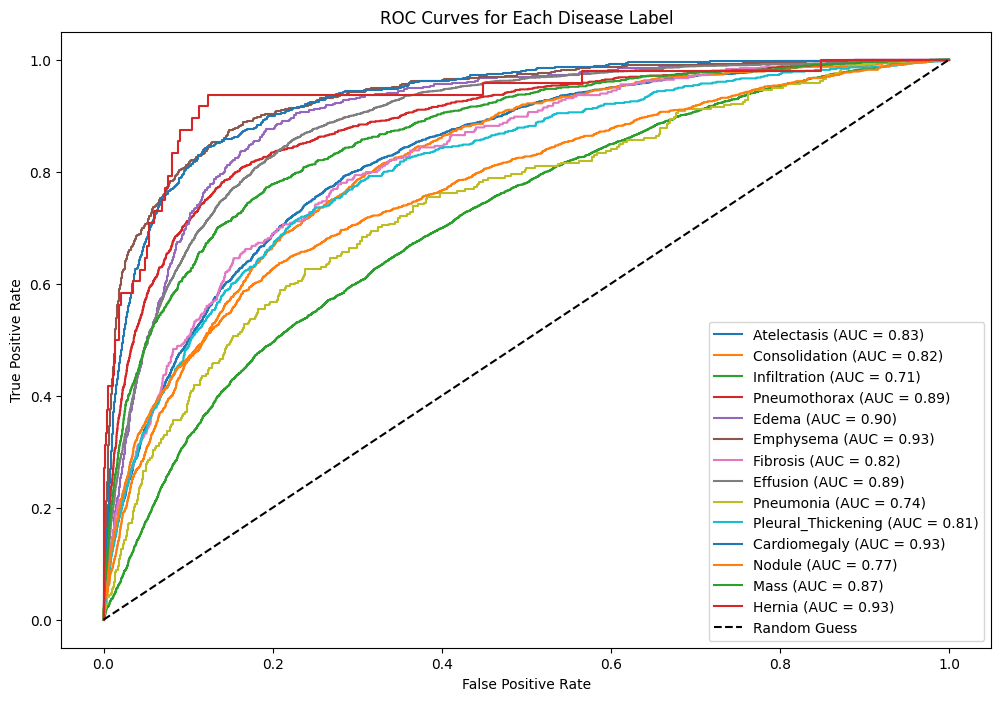

In [29]:
# Plot ROC curves
plt.figure(figsize=(12, 8))
for i, label in enumerate(disease_labels):
    fpr, tpr, _ = roc_curve(labels[:, i], preds[:, i])
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc_per_label[label]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Disease Label')
plt.legend(loc='lower right')
plt.show()

**Plot Training and Validation Loss**

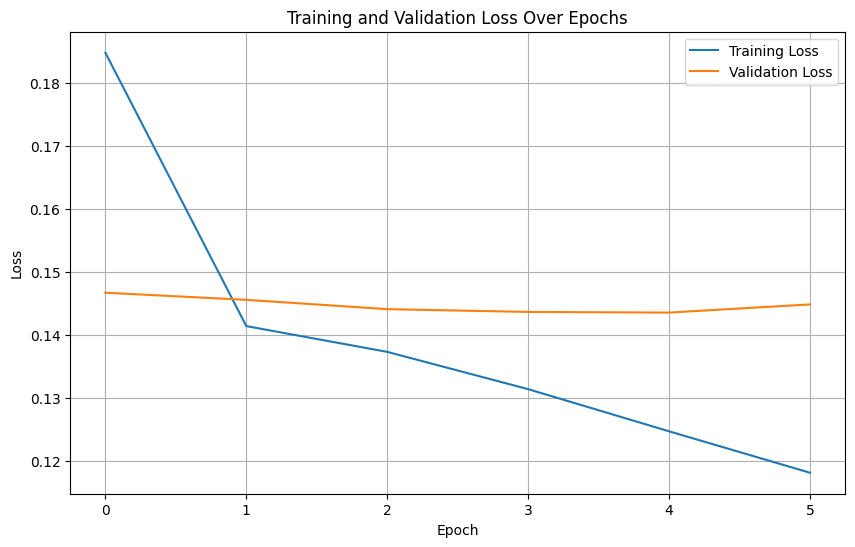

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot Validation AUC**

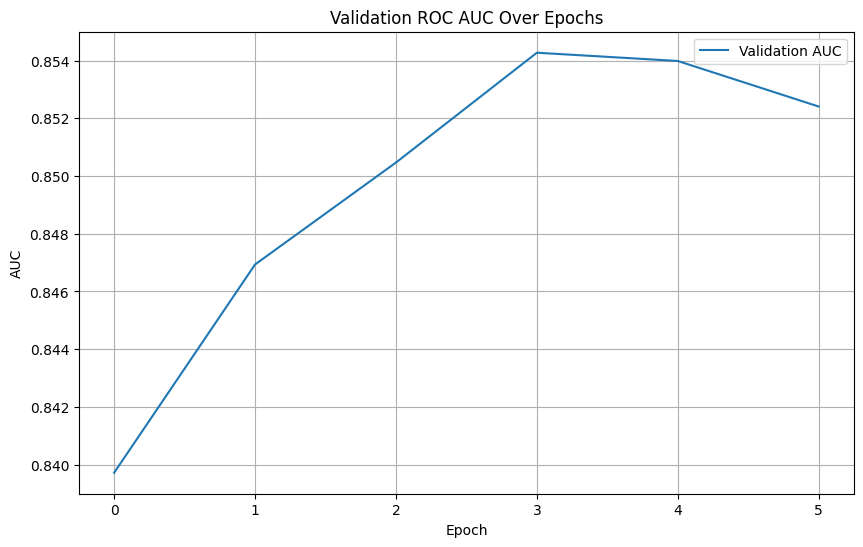

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(val_aucs, label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Validation ROC AUC Over Epochs')
plt.legend()
plt.grid(True)
plt.show()